This book is for the first edition of Kitaev Honeycombs in TeNPy.

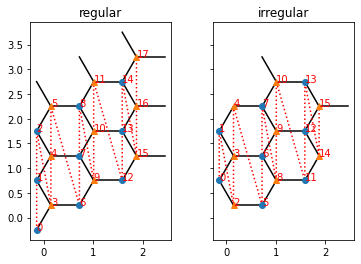

In [4]:
import matplotlib.pyplot as plt
from tenpy.models import lattice

Lx, Ly = 3, 3
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6, 4))

reg_lat = lattice.Honeycomb(Lx=Lx, Ly=Ly, sites=None, bc='periodic')
irr_lat = lattice.IrregularLattice(reg_lat, remove=[[0, 0, 0], [-1, -1, 1]])

for lat, label, ax in zip([reg_lat, irr_lat],
                          ["regular", "irregular"],
                          axes.flatten()):
    lat.plot_coupling(ax)
    lat.plot_order(ax, linestyle=':')
    lat.plot_sites(ax)
    ax.set_aspect('equal')
    ax.set_title(label)

plt.show()

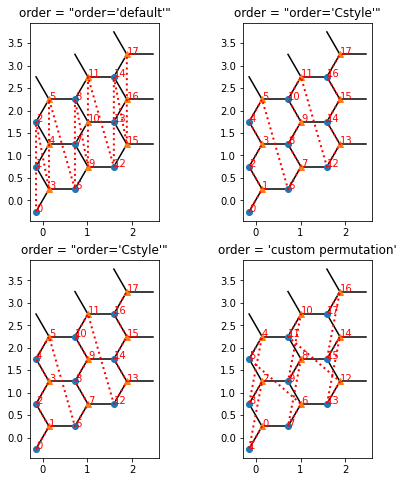

In [5]:
Lx, Ly = 3, 3
fig, axes = plt.subplots(2, 2, figsize=(7, 8))

lat1 = lattice.Honeycomb(Lx, Ly, sites=None, bc='periodic')  # default order
lat2 = lattice.Honeycomb(Lx, Ly, sites=None, bc='periodic',
                        order="Cstyle")  # first method to change order
# alternative: directly set "Cstyle" order
lat3 = lattice.Honeycomb(Lx, Ly, sites=None, bc='periodic')
lat3.order = lat2.ordering("Cstyle")  # now equivalent to lat2

# general: can apply arbitrary permutation to the order
lat4 = lattice.Honeycomb(Lx, Ly, sites=None, bc='periodic',
                        order="Cstyle")
old_order = lat4.order
permutation = []
for i in range(0, len(old_order), 2):
    permutation.append(i+1)
    permutation.append(i)
lat4.order = old_order[permutation, :]

for lat, label, ax in zip([lat1, lat2, lat3, lat4],
                          ["order='default'",
                           "order='Cstyle'",
                           "order='Cstyle'",
                           "custom permutation"],
                          axes.flatten()):
    lat.plot_coupling(ax)
    lat.plot_sites(ax)
    lat.plot_order(ax, linestyle=':', linewidth=2.)
    ax.set_aspect('equal')
    ax.set_title('order = ' + repr(label))

plt.show()

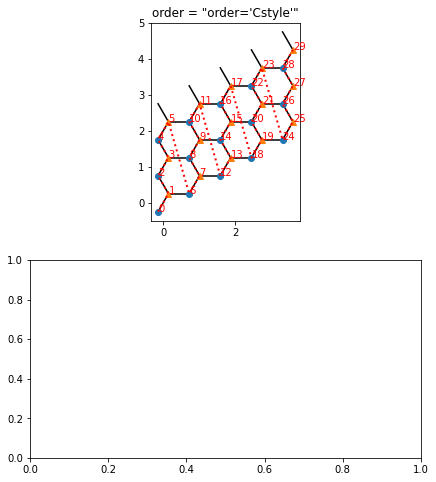

In [25]:
Lx, Ly = 5, 3
fig, axes = plt.subplots(2,1, figsize=(7, 8))

s = SpinSite(S=0.5, conserve=None)
lat2 = lattice.Honeycomb(Lx, Ly, sites=[s, s], bc=['open', 0],
                        order="Cstyle")  # first method to change order
for lat, label, ax in zip([lat2],
                          ["order='Cstyle'"],
                          axes.flatten()):
    lat.plot_coupling(ax)
    lat.plot_sites(ax)
    lat.plot_order(ax, linestyle=':', linewidth=2.)
    ax.set_aspect('equal')
    ax.set_title('order = ' + repr(label))

plt.show()

In [19]:
lat2.pairs

{'nearest_neighbors': [(0, 1, array([0, 0])),
  (1, 0, array([1, 0])),
  (1, 0, array([0, 1]))],
 'next_nearest_neighbors': [(0, 0, array([1, 0])),
  (0, 0, array([0, 1])),
  (0, 0, array([ 1, -1])),
  (1, 1, array([1, 0])),
  (1, 1, array([0, 1])),
  (1, 1, array([ 1, -1]))],
 'next_next_nearest_neighbors': [(1, 0, array([1, 1])),
  (0, 1, array([-1,  1])),
  (0, 1, array([ 1, -1]))],
 'fourth_nearest_neighbors': [(0, 1, array([0, 1])),
  (0, 1, array([1, 0])),
  (0, 1, array([ 1, -2])),
  (0, 1, array([ 0, -2])),
  (0, 1, array([-2,  0])),
  (0, 1, array([-2,  1]))],
 'fifth_nearest_neighbors': [(0, 0, array([1, 1])),
  (0, 0, array([ 2, -1])),
  (0, 0, array([-1,  2])),
  (1, 1, array([1, 1])),
  (1, 1, array([ 2, -1])),
  (1, 1, array([-1,  2]))]}

So for the default honeycomb in tenpy we can see that the bonds of nn are aligned as follows:
 - Jz
 - Jy
 - Jx

In [15]:
from tenpy.networks.site import Site, SpinHalfFermionSite, SpinHalfSite, GroupedSite, SpinSite
from tenpy.tools.misc import to_iterable, to_iterable_of_len, inverse_permutation
from tenpy.networks.mps import MPS  # only to check boundary conditions

from tenpy.models.lattice import Lattice, _parse_sites, Honeycomb
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.tools.params import get_parameter

In [31]:
class KitaevHoneycombModel(CouplingMPOModel):
    """
        Defining the MPO for Kitaev Honeycomb
    """
    def __init__(self, model_params):
        CouplingMPOModel.__init__(self, model_params)

    def init_sites(self, model_params):
        # conserve = get_parameter(model_params, 'conserve', None, self.name)
        conserve = model_params.get('conserve', None)
        S = model_params.get('S', 0.5) # by default spin one half
        fs = SpinSite(S=S, conserve=conserve)
        return [fs, fs]

    def init_lattice(self, model_params):
        Lx = model_params.get('Lx', 4) # 2 is the least possible number for L to be a Kitaev ladder we want, and 4 is more secured (I hope so)
        Ly = model_params.get('Ly', 3)
        
        gs = self.init_sites(model_params)
        model_params.pop("Lx")
        model_params.pop("Ly")


        order = model_params.get('order', 'Cstyle')
        bc = model_params.get('bc', 'open')
        bc_MPS=model_params.get('bc_MPS', 'finite')
        lattice_params = dict(
            order=order,
            bc=bc,
            bc_MPS=bc_MPS,
            basis=None,
            positions=None,
            nearest_neighbors=None,
            next_nearest_neighbors=None,
            next_next_nearest_neighbors=None,
            pairs={},
        )

#         lat = KitaevLadderSnakeCompact(L, gs, **lattice_params)
        lat = Honeycomb(Lx, Ly, sites=gs, **lattice_params)
        return lat

    def init_terms(self, model_params):
        # Jx = get_parameter(model_params, 'Jx', 1., self.name, True)
        # Jy = get_parameter(model_params, 'Jy', 1., self.name, True)
        # Jz = get_parameter(model_params, 'Jz', 1., self.name, True)
        Jx = model_params.get('Jx', 1.)
        Jy = model_params.get('Jy', 1.)
        Jz = model_params.get('Jz', 1.)

        u1, u2, dx = self.lat.pairs['nearest_neighbors'][0]
        self.add_coupling(Jz, u1, 'Sz', u2, 'Sz', dx)
        u1, u2, dx = self.lat.pairs['nearest_neighbors'][1]
        self.add_coupling(Jy, u1, 'Sy', u2, 'Sy', dx)
        u1, u2, dx = self.lat.pairs['nearest_neighbors'][2]
        self.add_coupling(Jx, u1, 'Sx', u2, 'Sx', dx)
#         for u1, u2, dx in self.lat.pairs['nearest_neighbors_y']:
#             self.add_coupling(Jy, u1, 'Sy', u2, 'Sy', dx)         
#         for u1, u2, dx in self.lat.pairs['nearest_neighbors_z']:
#             self.add_coupling(Jz, u1, 'Sz', u2, 'Sz', dx)
        

In [33]:
Jx = 1.0
Jy = 1.0
Jz = 1.0
S = 0.5
order='Cstyle'
Lx = 4
Ly = 3

verbose=True
bc='periodic'
bc_MPS='infinite'


model_params = dict(
    conserve=None, 
    Jx=Jx, 
    Jy=Jy, 
    Jz=Jz, 
    Lx=Lx, 
    Ly=Ly, 
    order='Cstyle',
    S=S,
    verbose=verbose,
    bc=bc,
    bc_MPS=bc_MPS,
    )

M = KitaevHoneycombModel(model_params)

Reading 'Lx'=4 for config KitaevHoneycombModel
Reading 'Ly'=3 for config KitaevHoneycombModel
Reading 'conserve'=None for config KitaevHoneycombModel
Reading 'S'=0.5 for config KitaevHoneycombModel
Reading 'order'='Cstyle' for config KitaevHoneycombModel
Reading 'bc'='periodic' for config KitaevHoneycombModel
Reading 'bc_MPS'='infinite' for config KitaevHoneycombModel
Reading 'Jx'=1.0 for config KitaevHoneycombModel
Reading 'Jy'=1.0 for config KitaevHoneycombModel
Reading 'Jz'=1.0 for config KitaevHoneycombModel


In [35]:
o = M.calc_H_MPO()

In [ ]:
def run_atomic(
    # model parameters
    chi=30, 
    Jx=1., 
    Jy=1., 
    Jz=1., 
    S=.5, 
    Lx=4, 
    Ly=3, 
    bc='periodic', 
    bc_MPS='infinite', 
    ####### dmrg parameters #######
    initial_psi=None, # input psi
    initial='random', 
    max_E_err=1.e-6, 
    max_S_err=1.e-4, 
    max_sweeps=200, 
    N_sweeps_check=10, 
    canonicalized=True, 
    mixer=True,
    mixer_params={
        'amplitude': 1.e-4,
        'decay': 1.2,
        'disable_after': 50
    },
    trunc_params={
        'chi_max': 4,
        'svd_min': 1.e-10,
    },
    # control for the verbose output
    verbose=1, 
):
    """ 
        The fundamental function for running DMRG
    """

    #######################
    # set the paramters for model initialization
    model_params = dict(
        conserve=None, 
        Jx=Jx, 
        Jy=Jy, 
        Jz=Jz, 
        L=L, 
        S=S,
        verbose=verbose,
        bc=bc,
        bc_MPS=bc_MPS,
        )
    # initialize the model
    M = KitaevLadderSnakeCompactModel(model_params)
    # providing a product state as the initial state
    # prod_state = ["up", "up"] * (2 * model_params['L'])
    # random generated initial state
    if initial_psi==None:
        prod_state = [ choice(["up", "down"]) for i in range(2 * L)]
        if initial == 'up':
            prod_state = ["up" for i in range(2 * L)]
        if initial == 'down':
            prod_state = ["down" for i in range(2 * L)]
        psi = MPS.from_product_state(
            M.lat.mps_sites(), 
            prod_state, 
            bc=M.lat.bc_MPS,
        )
    else:
        psi = initial_psi.copy()
    #######################

    
    #######################
    # set the parameters for the dmrg routine
    dmrg_params = {
        'start_env': 10,
#         'mixer': False,  # setting this to True helps to escape local minima
        'mixer': mixer,
        'mixer_params': mixer_params,
        'trunc_params': trunc_params,
        'max_E_err': max_E_err,
        'max_S_err': max_S_err,
        'max_sweeps': max_sweeps,
        'N_sweeps_check': N_sweeps_check,
        'verbose': verbose,
    }
    #######################
    
    if verbose:
        print("\n")
        print("=" * 80)
        print("="*30 + "START" + "="*30)
        print("=" * 80)
        print("Chi = ", chi, '\n')

    eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    eng.reset_stats()
    eng.trunc_params['chi_max'] = chi
    info = eng.run()

    if canonicalized:
        psi.canonical_form()
        if verbose:
            print("Before the canonicalization:")
            print("Bond dim = ", psi.chi)

            print("Canonicalizing...")
            psi_before = psi.copy()


        if verbose:
            ov = psi.overlap(psi_before, charge_sector=0)
            print("The norm is: ",psi.norm)
            print("The overlap is: ", ov)
            print("After the canonicalization:")
            print("Bond dim = ", psi.chi)

        print("Computing properties")

    energy=info[0]

    if verbose:
        print("Optimizing")

    tenpy.tools.optimization.optimize(3)

    if verbose:
        print("Loop for chi=%d done." % chi)
        print("=" * 80)
        print("="*30 + " END " + "="*30)
        print("=" * 80)
        
    # the wave function, the ground-state energy, and the DMRG engine are all that we need
    result = dict(
        psi=psi.copy(),
        energy=energy,
        sweeps_stat=eng.sweep_stats.copy(),
        parameters=dict(
            # model parameters
            chi=chi,
            Jx=Jx, 
            Jy=Jy, 
            Jz=Jz, 
            L=L, 
            # dmrg parameters
            initial_psi=initial_psi,
            initial=initial,
            max_E_err=max_E_err,
            max_S_err=max_S_err,
            max_sweeps=max_sweeps,
        )
    )
    return result